In [7]:
import numpy as np
import soundfile as sf

Sampling rate for every signal:

In [8]:
sr = 22050

Lectura de archivos de audio:

In [9]:
import librosa as lb
from IPython.display import Audio

#%% Lectura de archivos de audio 
samples, sampling_rate= lb.load("../Data/Train/ADS_train_audio_22kHz.wav", sr=sr, mono=True,offset=0.0,duration=None)
# Duración en segundos:
duration = len(samples)/sampling_rate
# Escuchar el audio:
Audio("../Data/Train/ADS_train_audio_22kHz.wav")
duration

2.043356009070295

In [10]:
# Cargar respuesta al impulso:
ir_samples, ir_sampling_rate= lb.load("../Data/Train/ir_golpe22_short.wav", sr=sr, mono=True,offset=0.0,duration=None)
ir_duration = len(ir_samples)/ir_sampling_rate
ir_duration

0.16072562358276643

In [12]:
ts_samples, ts_sr = lb.load("../Data/Train/QueenWatch1.wav", sr=sr, mono=True,offset=0.0,duration=None)
ts_duration = len(ts_samples)/ts_sr
ts_duration

3.766439909297052

### Plot audio signals:

In [13]:
import matplotlib.pyplot as plt
import librosa.display

### Original Speech Signal:

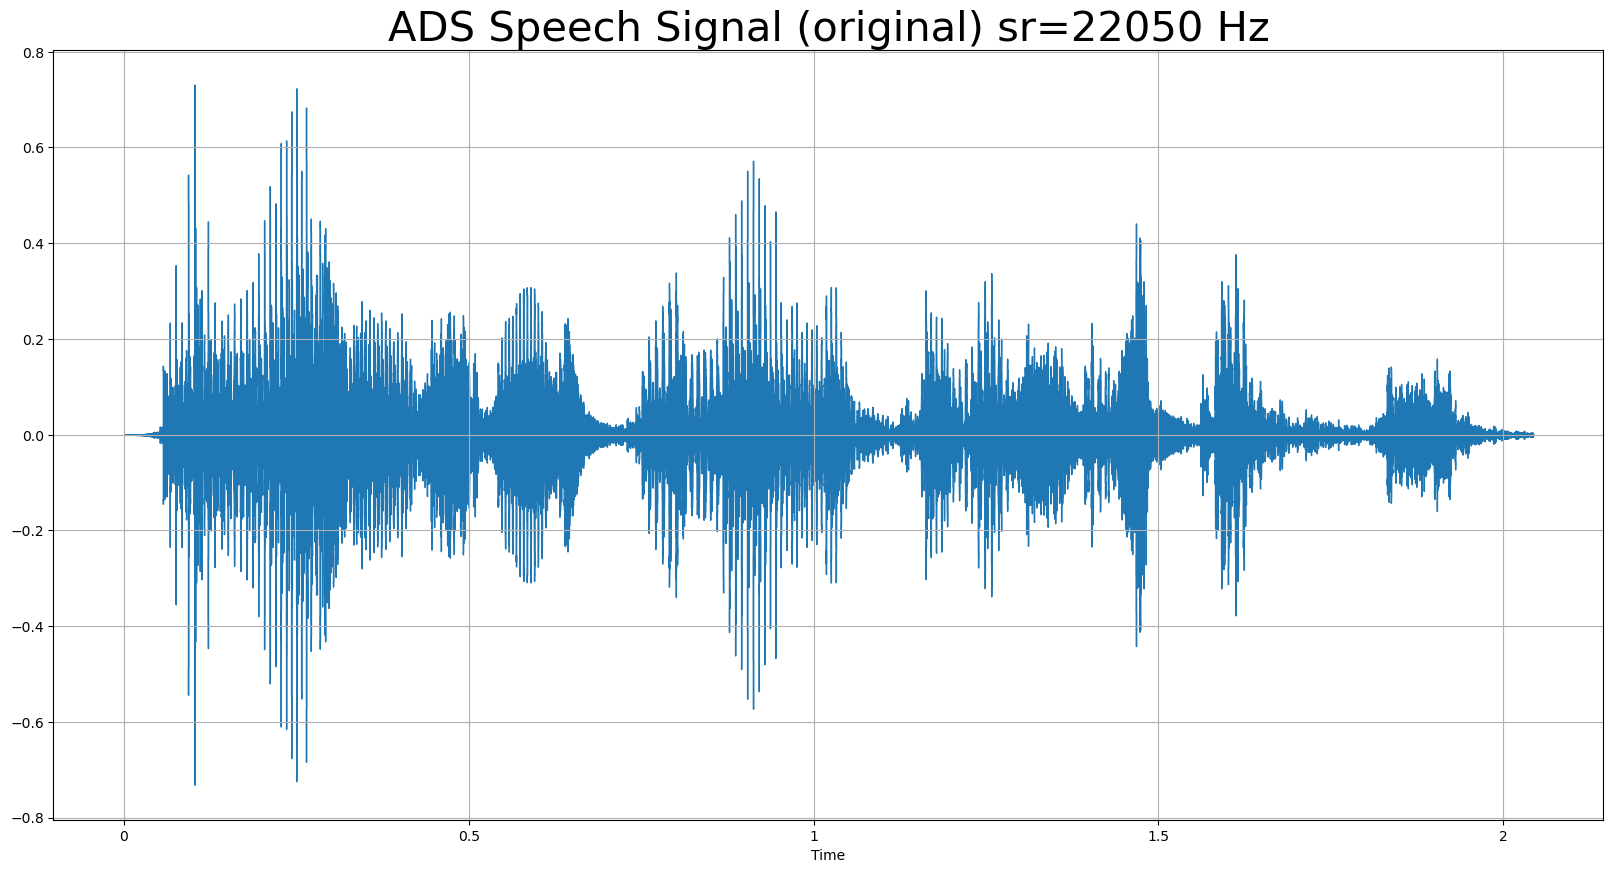

In [55]:
fig = plt.figure(figsize=(20,10))
plt.title(f'ADS Speech Signal (original) sr = {sr} Hz',fontsize=30)
plt.grid()
lb.display.waveshow(y=samples,sr=sr)
plt.show()
fig.savefig(f'../Figures/Original_signal_sr={sr}')


### Impulse Response Signal:

**Sampling rate:** 22.050 kHz

**Length:** seconds 

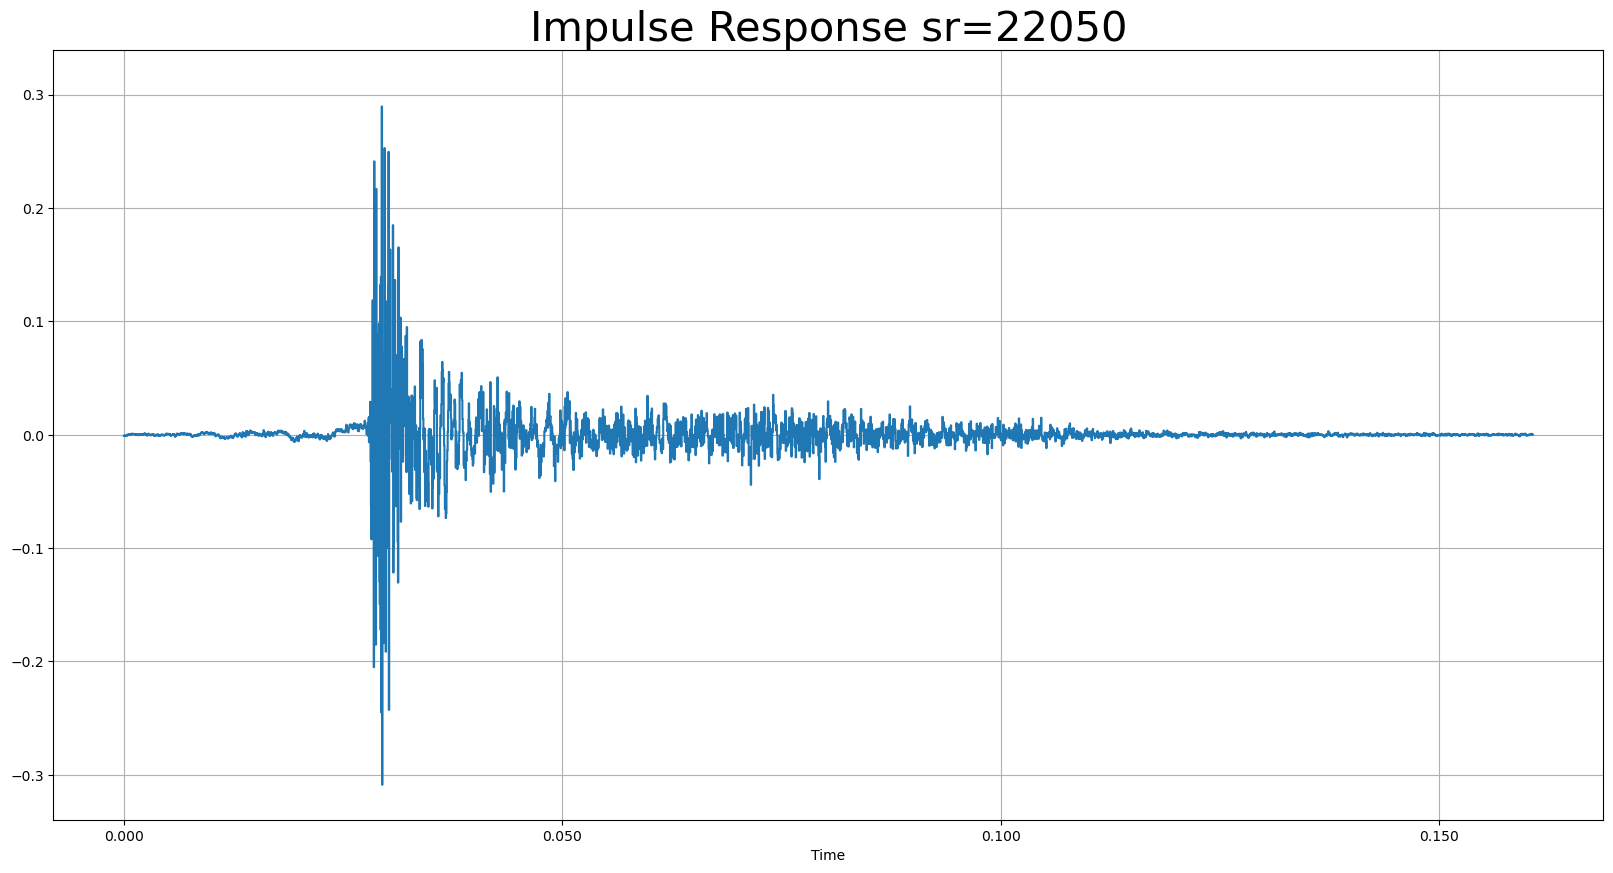

In [24]:
fig = plt.figure(figsize=(13,8))
plt.title(f'Impulse Response sr={ir_sampling_rate}', fontsize=30)
plt.grid()
lb.display.waveshow(y=ir_samples,sr=ir_sampling_rate)
plt.show()
fig.savefig(f'../Figures/Impulse_Response_sr={ir_sampling_rate}')

### Convolution between train signals and impulse response

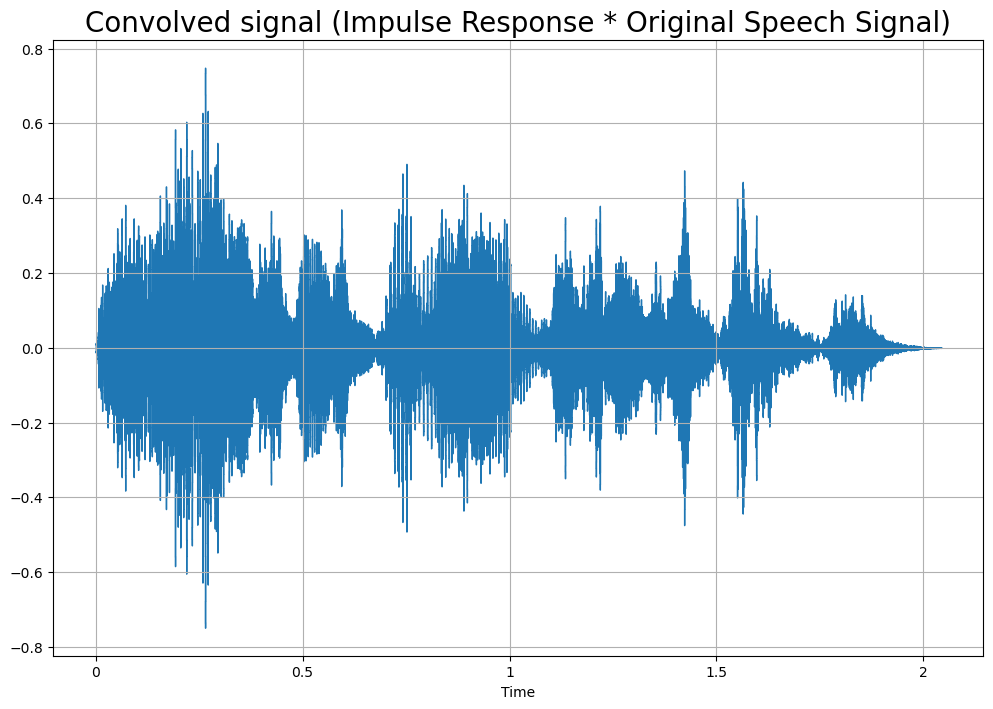

In [14]:
# Convolución de numpy:
conv_signal = np.convolve(samples, ir_samples, mode='same')
# Plot the resulting singal:
fig = plt.figure(figsize=(12,8))
plt.title('Convolved signal (Impulse Response * Original Speech Signal)',fontsize=20)
plt.grid()
lb.display.waveshow(y=conv_signal,sr=sr)
plt.show()
fig.savefig(f'../Figures/Convolved_signal')
conv_signal.astype(np.int16).tofile('../Data/Train/conv_signal.wav')
sf.write('../Data/Train/convolved_signal.wav',conv_signal, sr, subtype=None)

---

Delayed Signal (Lags) Matrix generation

In [16]:
n_lag = 5
n_lag_range = np.array([i for i in range(0,n_lag)])
n_lag_range
dim_conv_signal = np.shape(conv_signal)
dim_conv_signal

(45056,)

In [18]:
# Lag matrix of dimmensions: convolved signal - lag number (rows) x lag number (columns)
lag_matrix = np.zeros((dim_conv_signal[0]-n_lag, n_lag))
for i in range(n_lag):
        lag_matrix[:,i] = conv_signal[i : dim_conv_signal[0]-n_lag+i]
# del_sig = conv_signal[2:-1]
# del_sig2 = conv_signal[1:-2]
# del_sig3 = conv_signal[:-3]

# del_sig = conv_signal[:-7]
# del_sig2 = conv_signal[1:-6]
# del_sig3 = conv_signal[2:-5]
# del_sig4 = conv_signal[3:-4]
# del_sig5 = conv_signal[4:-3]
# del_sig6 = conv_signal[5:-2]
# del_sig7 = conv_signal[6:-1]
# matrix = np.c_[del_sig, del_sig2, del_sig3]
# matrix7 = np.c_[del_sig, del_sig2, del_sig3, del_sig4, del_sig5, del_sig6, del_sig7]
lag_matrix.shape

(45051, 5)

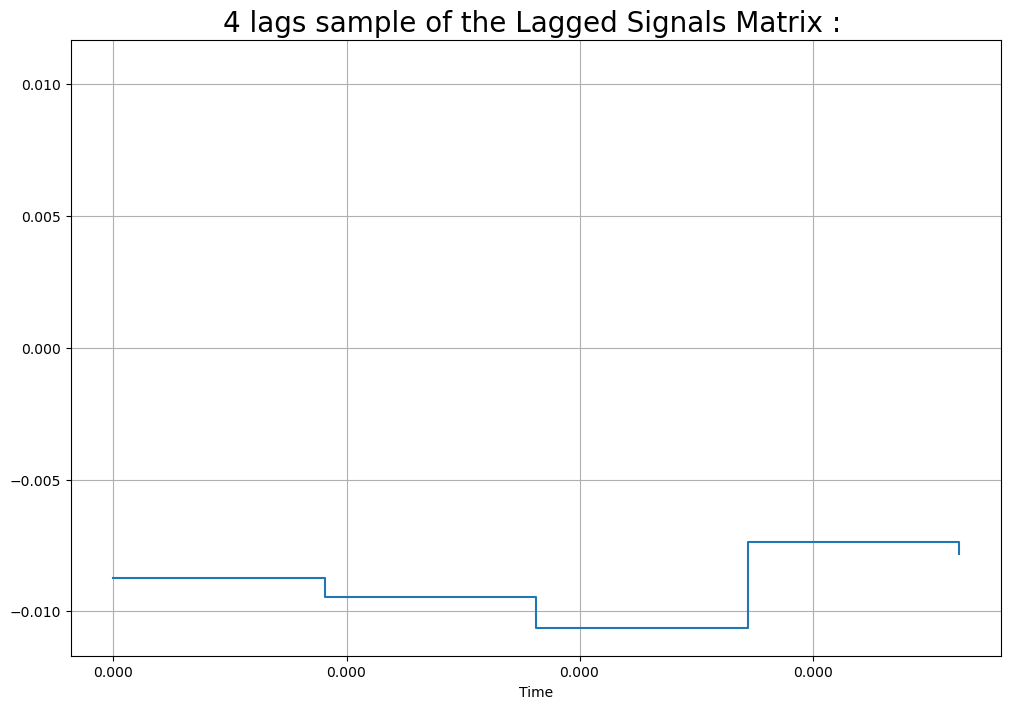

In [19]:
# Random plot one of the lagged signals:
r_int = np.random.randint(0,n_lag)
fig = plt.figure(figsize=(12,8))
plt.title(f'{r_int} lags sample of the Lagged Signals Matrix : ',fontsize=20)
plt.grid()
lb.display.waveshow(y=lag_matrix[r_int],sr=sr)
plt.show()

# Train dataset and Test dataset split



In [183]:
X_train = lag_matrix
X_train.shape

(45051, 5)

In [184]:
Y_train = samples[n_lag:]
Y_train.shape

(45051,)

# Time-Delay Neural Network model

In [94]:
!pip show keras tensorflow

Name: keras
Version: 2.11.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages
Requires: 
Required-by: tensorflow
---
Name: tensorflow
Version: 2.11.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


### Hyperparameters:

In [156]:
# Epochs:
TDNN_epochs = 200
# Learning Rate:
TDNN_lr = 0.05
# Decay Rate:
TDNN_dr = TDNN_lr/TDNN_epochs
# Momentum:
TDNN_momentum = 0.8
# Batch Size:
TDNN_batch_size = 200

In [157]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Model definition:
def Time_Delay_NN(no_layers, input_layer, hiden_layer1, hiden_layer2):
    
    TDNN_model = Sequential()
    # Neurons
    nn_i, nn_h1, nn_h2 = input_layer, hiden_layer1, hiden_layer2
    
    # Layer(s) definition:
    TDNN_model.add(Dense(nn_i, input_shape=(n_lag,), activation="tanh", name="input_layer_2"))
    TDNN_model.add(Dense(nn_h1, activation="tanh", name="hidden_layer_1"))
    # model.add(Dense(nn_h2, activation="tanh", name="hidden_layer_2"))
    # model.add(TDNNLayer([-5,2],True, input_shape=(45053,1), activation="tanh"))

    # Output for Regression:
    TDNN_model.add(Dense(1, activation='linear', name="output_layer"))
    
    return TDNN_model

TDNN_model = Time_Delay_NN(3, 10, 5, 5)
# Compile model:
TDNN_model.compile(optimizer=Adam(learning_rate =Tdnn_lr), loss='MeanSquaredError', metrics=['mse'])
x_train = lag_matrix
# xtrain = preprocessing.scale(xtrain)
y_train = samples[n_lag:]

### Train Model

In [158]:
TDNN_model_hist = TDNN_model.fit(x_train, y_train, epochs=Epochs, batch_size=Batch_size, verbose=0)
TDNN_model_hist

### Plot the loss function and the metrics

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


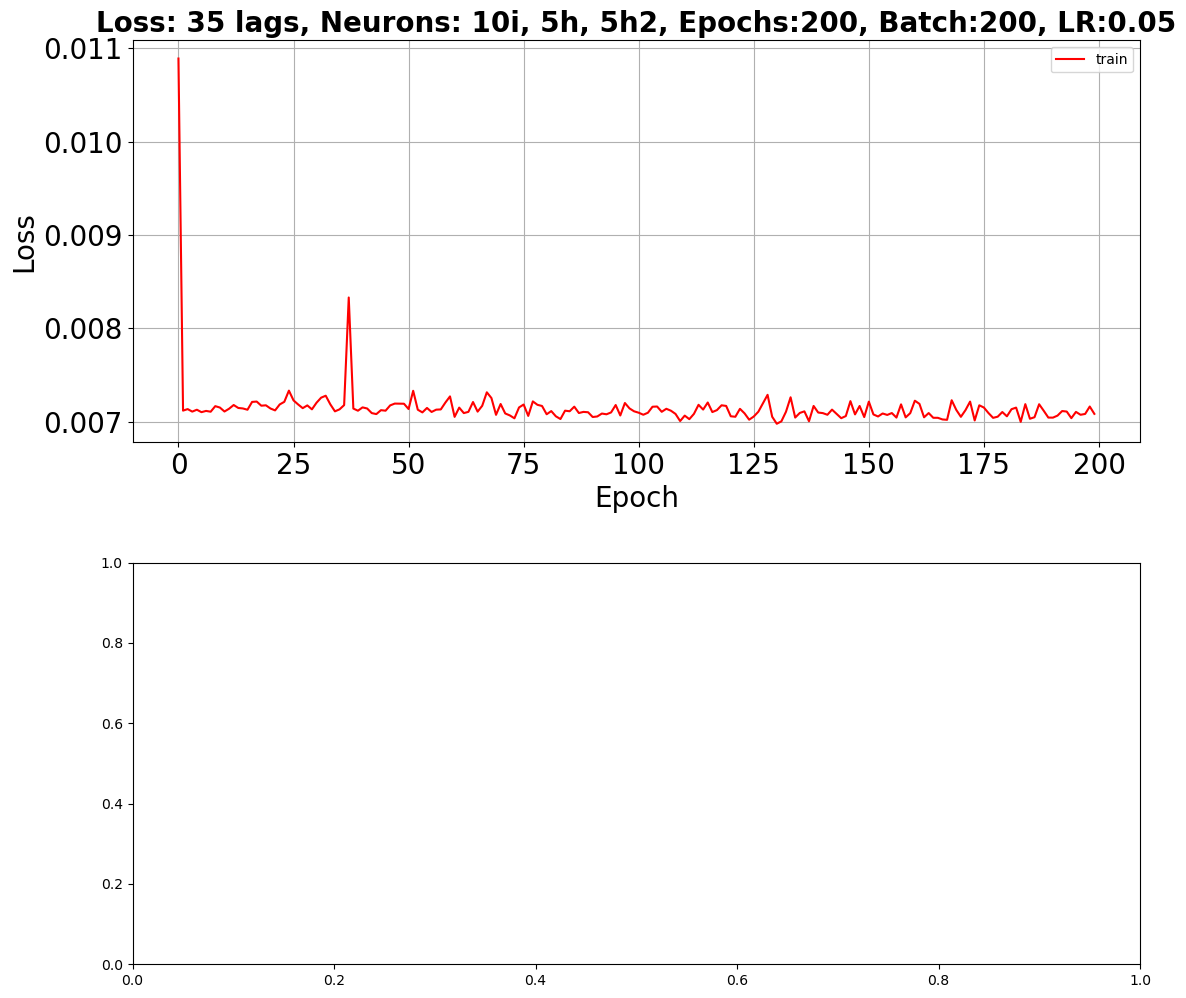

In [112]:

fig, axs = plt.subplots(2, 1, figsize=(13,12))
fig.subplots_adjust(hspace=0.3)
axs[0].set_title(f'Loss: {n_lag} lags, Neurons: {nn_i}i, {nn_h1}h, {nn_h2}h2, Epochs:{Epochs}, Batch:{Batch_size}, LR:{Learning_rate}', fontsize=20, fontname="Times New Roman", fontweight='bold')
axs[0].plot(m_hist.history['loss'], 'r', label='train')
# ax.plot(m_hist.history['val_loss'], 'b' ,label='val')
axs[0].set_xlabel(r'Epoch', fontsize=20)
axs[0].set_ylabel(r'Loss', fontsize=20)
axs[0].grid(True)
axs[0].legend()
axs[0].tick_params(labelsize=20)

### Plot the Mean-Square Error

In [113]:
# fig, axs = plt.subplots(2, 2, figsize=(10,6))
# ax.plot(np.sqrt(m_hist.history['mean_squared_error']), 'r', label='train')
# ax.plot(np.sqrt(m_hist.history['val_mean_squared_error']), 'b' ,label='val')
axs[1].set_title(f'MSE: {n_lag} lags, Neurons: {nn_i}i, {nn_h1}h, {nn_h2}h2, Epochs:{Epochs}, Batch:{Batch_size}, LR:{Learning_rate}', fontsize=20, fontname="Times New Roman", fontweight='bold')
axs[1].plot(np.sqrt(m_hist.history['mse']), 'r', label='train')
# ax.plot(np.sqrt(m_hist.history['val_mse']), 'b' ,label='val')
axs[1].set_xlabel(r'Epoch', fontsize=20)
axs[1].set_ylabel(r'MSE', fontsize=20)
axs[1].grid(True)
axs[1].legend()
axs[1].tick_params(labelsize=20)
#fig.savefig(f'../Figures/Loss_MSE_{n_lag}lags_{nn_i}i_{nn_h1}h1_{nn_h2}h2_{Epochs}e_{Batch_size}bs_{Learning_rate}lr.png')

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


In [122]:
!pip show pydot pydotplus graphviz

Name: pydot
Version: 1.4.2
Summary: Python interface to Graphviz's Dot
Home-page: https://github.com/pydot/pydot
Author: Ero Carrera
Author-email: ero.carrera@gmail.com
License: MIT
Location: /home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages
Requires: pyparsing
Required-by: 
---
Name: pydotplus
Version: 2.0.2
Summary: Python interface to Graphviz's Dot language
Home-page: http://pydotplus.readthedocs.org/
Author: PyDotPlus Developers
Author-email: carlos@jenkins.co.cr
License: 
Location: /home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages
Requires: pyparsing
Required-by: 
---
Name: graphviz
Version: 0.20.1
Summary: Simple Python interface for Graphviz
Home-page: https://github.com/xflr6/graphviz
Author: Sebastian Bank
Author-email: sebastian.bank@uni-leipzig.de
License: MIT
Location: /home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages
Requires: 
Required-by: 


In [127]:
#%% View model
from tensorflow.keras.utils import plot_model
plot_model(TDNN_model, to_file='../Figures/TDNN_model.png', show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Prediction

1407/1407 [==============================] - 2s 1ms/step


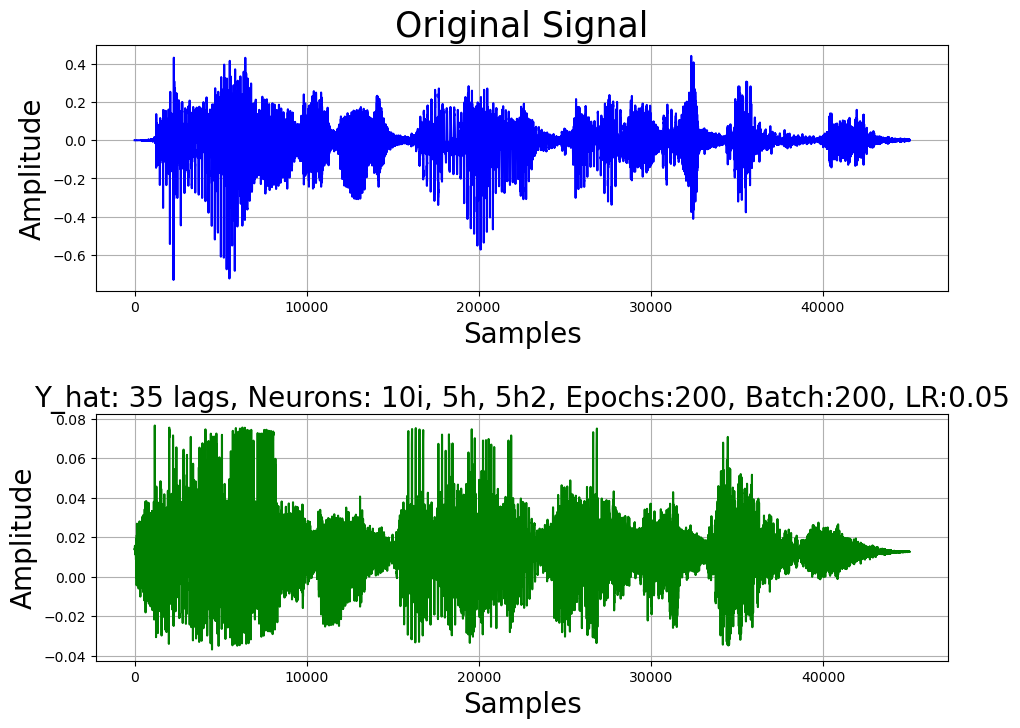

In [159]:
y_pred = TDNN_model.predict(x_train)

# Plotting original signal:
fig, axs = plt.subplots(2, 1, figsize=(11,8))
fig.subplots_adjust(hspace=0.5)
#plt.tight_layout(pad=0.5)
axs[0].set_title(f'Original Signal', fontsize=25)
axs[0].plot(samples,c='b')
axs[0].set_xlabel('Samples', fontsize=20)
axs[0].set_ylabel('Amplitude', fontsize=20)
axs[0].grid(True)

# Plotting predicted signal (y hat):
# fig = plt.figure(figsize=(20,10))
axs[1].set_title(f'Y_hat: {n_lag} lags, Neurons: {nn_i}i, {nn_h1}h, {nn_h2}h2, Epochs:{Epochs}, Batch:{Batch_size}, LR:{Learning_rate}', fontsize=20)
axs[1].plot(y_pred,c='g')
axs[1].set_xlabel('Samples', fontsize=20)
axs[1].set_ylabel('Amplitude', fontsize=20)
axs[1].grid(True)
plt.show()
fig.savefig(f'../Figures/y_hat_{n_lag}lags_{nn_i}i_{nn_h1}h_{nn_h2}h2_{Epochs}e_{Batch_size}bs_{TDNN_lr}lr.png', dpi=450 )

# Save to sound file:
sf.write(f'../Data/predicted_signal_{n_lag}lags_{nn_i}i_{nn_h1}h1_{nn_h2}h2_{Epochs}e_{Batch_size}bs_{TDNN_lr}lr.wav',y_pred, sampling_rate, subtype=None)


### Performance Evaluation:

In [161]:
from sklearn.metrics import r2_score,mean_squared_error,make_scorer

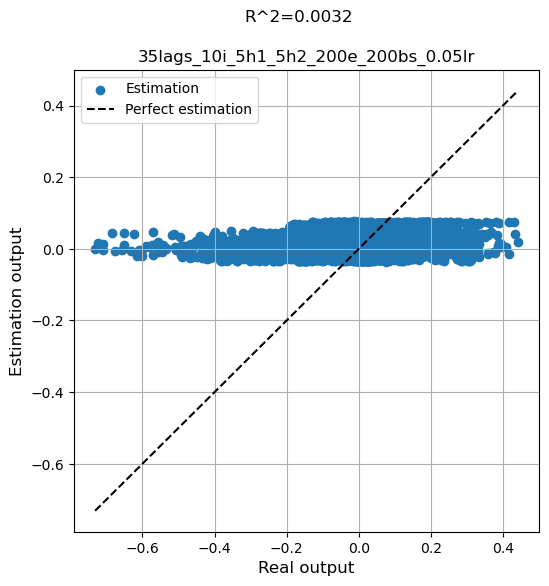

In [171]:
R2_score = r2_score(y_train,y_pred)

x_min,x_max = min(y_train),max(y_train)
xline = np.linspace(x_min,x_max)

fig = plt.figure(figsize=(6,6))
plt.scatter(ytrain,y_pred,label='Estimation')
plt.plot(xline,xline,'k--',label='Perfect estimation')
plt.xlabel('Real output', fontsize=12)
plt.ylabel('Estimation output', fontsize=12)
plt.suptitle('R^2=%0.4f'%R2_score, fontsize=12)
plt.title(f'{n_lag}lags_{nn_i}i_{nn_h1}h1_{nn_h2}h2_{Epochs}e_{Batch_size}bs_{Learning_rate}lr', fontsize=12)
plt.legend()
plt.grid()
plt.show()
fig.savefig(f'../Figures/R2_{n_lag}lags_{nn_i}i_{nn_h1}h1_{nn_h2}h2_{Epochs}e_{Batch_size}bs_{TDNN_lr}lr.png', dpi=450)


In [ ]:

#%%  Test

# Queen_y_pred = model.predict(ts_samples)
# sf.write('../Data/queen_predicted_signal.wav',Queen_y_pred, ts_sampling_rate, subtype=None)
# plt.show()
# plt.figure()
# plt.title('Queen Predicted Signal')
# plt.plot(Queen_y_pred,c='r')

# score = model.evaluate(matrix, samples[3:])
# print('Test loss:', score[0])
# print('Test mse:', score[1])

# corr = sig.correlate(y_pred, y_pred)

# plt.figure()
# plt.title('Signals Correlation')
# plt.plot(corr)
# plt.show()

#%% Hyperparameter tunning
from sklearn.model_selection import GridSearchCV

# RandomSearchCV


In [ ]:

# save weights to HDF5
model.save_weights("../Figures/TDNN_model.h5")
print("Model saved")

#%% Retrieve the model: load json and create model
# from keras.models import model_from_json
# json_file = open('../Figures/TDNN_model.json', 'r')
# saved_model = json_file.read()
# close the file as good practice:
# json_file.close()
# model_ = model_from_json(saved_model)
# load weights into new model:
# model_.load_weights("../Figures/TDNN_model.h5")
# print("Model loaded")


# XGBoost Model

In [206]:
!pip show xgboost

Name: xgboost
Version: 1.5.1
Summary: XGBoost Python Package
Home-page: https://github.com/dmlc/xgboost
Author: 
Author-email: 
License: Apache-2.0
Location: /home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages
Requires: numpy, scipy
Required-by: 


In [2]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [176]:
xgb_model = xgb.XGBRegressor()
xgb_model

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

### Parameter Definition:

In [181]:
param_grid = {
    'n_estimators': range(100, 200, 10), # De 50 hasta 250 estimadores en aumentos de 50
    'learning_rate': [0.05, 0.1, 0.3, 1], # Eta
    'max_depth': range(2, 5, 1),
    'subsample': [0.2, 0.5, 0.7, 1] # Submuestreo aleatorio para prevenir overfitting
}

In [189]:
grid_search = GridSearchCV(estimator=xgb_model, 
                  param_grid=param_grid,
                  #scoring='neg_mean_squared_error',
                  scoring='r2',
                  n_jobs=1, # All proceiisors
                  cv=5,
                  verbose=1)

grid_search.fit(X_train, Y_train)
print("Mejores parámetros:",grid_search.best_params_)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.2; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.2; total time=   0.5s
[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.2; total time=   0.5s
[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.2; total time=   0.5s
[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.2; total time=   0.5s
[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.5; total time=   0.8s
[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.5; total time=   0.7s
[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.5; total time=   0.8s
[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.5; total time=   0.7s
[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.5; total time=   0

best_params = {
    'n_estimators': 110, # De 50 hasta 250 estimadores en aumentos de 50
    'learning_rate': 0.05, # Eta
    'max_depth': 2,
    'subsample': 0.2
    }
xgb_best_model = xgb.XGBRegressor(
                             n_estimators = best_params['n_estimators'],
                             max_depth = best_params['max_depth'],
                             eval_metric = 'r2',
                             learning_rate = best_params['learning_rate'],
                             verbosity = 4,
                             n_jobs = -1,
                             gamma = 1,)

In [210]:
xgb_best_model = grid_search.best_estimator_
xgb_best_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=110, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.2,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### Save model for model persistence:

In [4]:
import pickle

In [192]:
xgb_best_model.save_model("../Models/xgb_best_model.json")
pickle.dump(xgb_best_model, open("../Models/xgb_best_model.pkl", "wb"))

In [5]:
def load_pkl(fname):
    with open(fname, 'rb') as f:
        obj = pickle.load(f)
    return obj

xgb_best_model = load_pkl('../Models/xgb_best_model.pkl')
xgb_best_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=110, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.2,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Realizar predicción sobre la señal original:

In [6]:
xgb_best_Yhat = xgb_best_model.predict(samples)
xgb_best_Yhat.shape

NameError: name 'samples' is not defined

### Calcular scores de la predicción del modelo:

In [200]:
xgb_best_rmse = (mean_squared_error(Y_train, xgb_best_Yhat)**0.5)
xgb_best_mae = mean_absolute_error(Y_train, xgb_best_Yhat)
xgb_best_mape = mean_absolute_percentage_error(Y_train, xgb_best_Yhat)
xgb_best_r2 = r2_score(Y_train, xgb_best_Yhat)
print('RMSE: {0:.3f}'.format(xgb_best_rmse))
print('MAE: {0:.3f}'.format(xgb_best_mae))
print('MAPE: {0:.3f}'.format(xgb_best_mape))
print('R^2: {0:.3f}'.format(xgb_best_r2))

RMSE: 0.084
MAE: 0.055
MAPE: 18618374144.000
R^2: 0.026


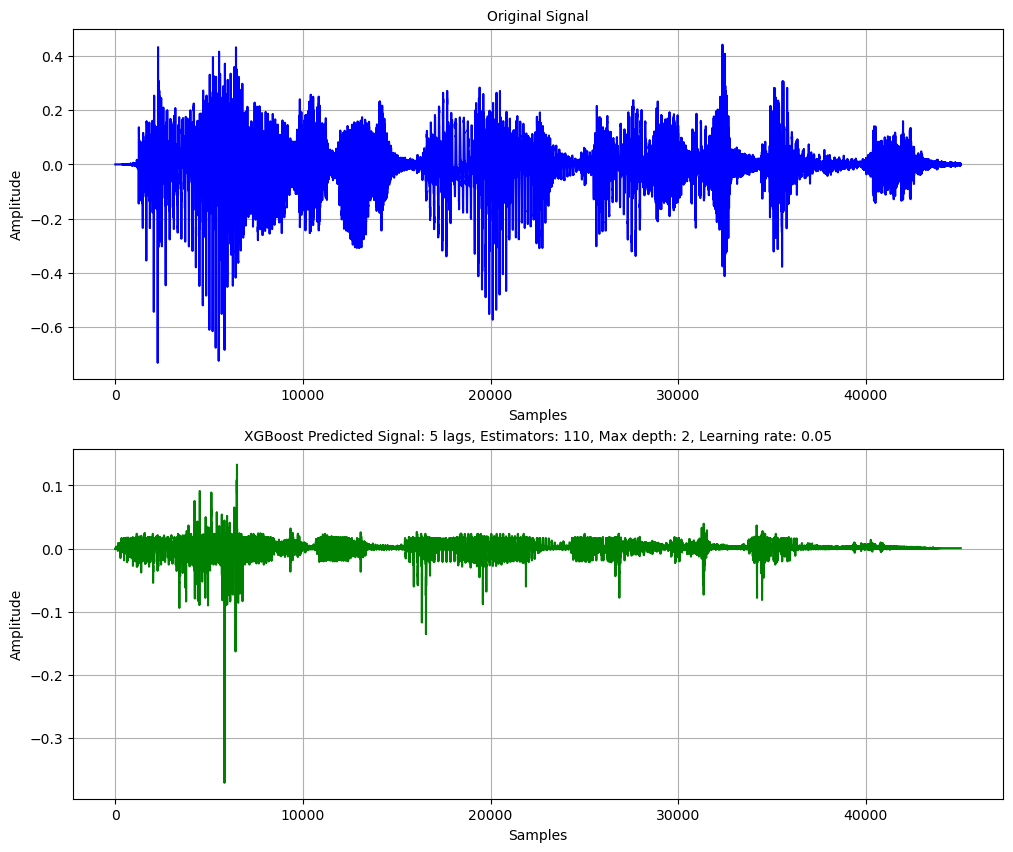

In [223]:

# Plotting original signal:
fig, axs = plt.subplots(2, 1, figsize=(12,10))
fig.subplots_adjust(hspace=0.2)
# plt.tight_layout(pad=0.7)
axs[0].set_title(f'Original Signal', fontsize=10)
axs[0].plot(samples,c='b')
axs[0].set_xlabel('Samples', fontsize=10)
axs[0].set_ylabel('Amplitude', fontsize=10)
axs[0].grid(True)

# Plotting predicted signal (y hat):
# fig = plt.figure(figsize=(20,10))
axs[1].set_title(f'XGBoost Predicted Signal: {n_lag} lags, Estimators: {xgb_best_model.n_estimators}, Max depth: {xgb_best_model.max_depth}, Learning rate: {xgb_best_model.learning_rate}', fontsize=10)
axs[1].plot(xgb_best_Yhat,c='g')
axs[1].set_xlabel('Samples', fontsize=10)
axs[1].set_ylabel('Amplitude', fontsize=10)
axs[1].grid(True)
plt.show()
fig.savefig(f'../Figures/xgb_yhat_{n_lag}lags_{xgb_best_model.n_estimators}estimators_{xgb_best_model.max_depth}mdepth_{xgb_best_model.learning_rate}lr.png', dpi=450 )


In [218]:
# Save to sound file:
sf.write(f'../Data/Test/xgb_predicted_signal_xgb_yhat_{n_lag}lags_{xgb_best_model.n_estimators}estimators_{xgb_best_model.max_depth}mdepth_{xgb_best_model.learning_rate}lr.wav',xgb_best_Yhat, sr, subtype=None)


In [198]:
# Graph and save the predicted signal:


#%% Save a model to JSON

# serialize model to JSON
model_json = model.to_json()

with open("../Figures/TDNN_model.json", "w") as json_file:
    json_file.write(model_json)


ValueError: Found input variables with inconsistent numbers of samples: [45056, 45051]